<h1>Session 11. Fully tuned Decision Tree with Turnover data</h1>
<p>This notebook provides an example code of predicting churn of employees by using <b>Decision tree classification</b> with Turnover data. 
<br>

The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of our variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables, and see that there are many correlated variables
<li>Devide data into training and testing sets
<li>Construct the <b>1st Decision tree</b> without setting any parameters, get accuracy score fot training and testing sets
<li>Construct confusion matrix, calculate recall
<li>Construct <b>the 2nd Decision tree</b>,calculate train and test accuracy scores, recall
<li>Construct <b>the 3rd Decision tree</b> using the results of <b>cross-validation (GridSearchCV)</b>
<li>Construct <b>the 4th Decision tree</b> using balanced class weights, calculate train and test accuracy scores, recall
<li>Construct <b>the 5th Decision tree</b> using the most important features 
<li>Compare the results
</ol>
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit 
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from  sklearn.metrics import recall_score

In [2]:
data=pd.read_csv('turnover.csv')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#no missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
work_accident            14999 non-null int64
churn                    14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
data_numeric = data.select_dtypes(exclude="object")
data_object = data.select_dtypes(include="object")

In [5]:
#checking for 0 variance
#there is no variable with 0 var, so we will keep all numeric variables
data_numeric.var()==0

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
work_accident            False
churn                    False
promotion_last_5years    False
dtype: bool

In [6]:
#checking to see whether there is object variable with one category, if there is one, we should remove
for i in data_object.columns:
    print(data_object[i].unique())

['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
['low' 'medium' 'high']


In [7]:
#converting object variables into dummy variables
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

In [8]:
data_final=data_numeric.join(data_dummies)

# Decision Tree

In [13]:
#let's see percenatage of employees who didn't churn,
#and percenatage of employees who churned 
print(data_final.churn.value_counts()/len(data_final)*100)

0    76.191746
1    23.808254
Name: churn, dtype: float64


<b>About 76% of employees didn't churn.This means that without any model we will probably clasify a new record (a new employee) as 0 with accuracy of 76%, but we want to do better than this very naive classification.</b>

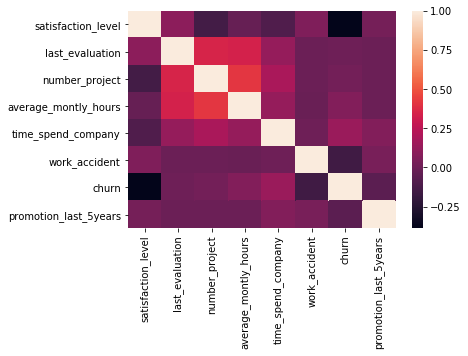

In [10]:
sns.heatmap(data.corr())
plt.show()

In [11]:
Y=data_final.churn
X=data_final.drop("churn",axis=1)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

# Tree 1- With Default Parameters

In [12]:
#running and fitting DT
tree_1=DecisionTreeClassifier(random_state=42)
tree_1.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [15]:
#to check accuracy scores for training and testing data to see that testing set solves overfitting problem
print("Train:",tree_1.score(x_train,y_train)*100)
print("Test:",tree_1.score(x_test,y_test)*100)

Train: 100.0
Test: 97.36


In [16]:
#to calculate before constructing confusion matrix
y_pred = tree_1.predict(x_test)  
print(confusion_matrix(y_test, y_pred))

[[2788   65]
 [  34  863]]


<b>Here we can see that 99(65+34) cases were misclassified</b>

In [17]:
#sensitivity (TPR)
print("Recall or TPR or Sensitivity:",recall_score(y_test,y_pred))

Recall or TPR or Sensitivity: 0.9620958751393534


In [18]:
#confusion matrix, recall (1) is sensitivity (TPR) and recall(0) is specificity (TNR)
print(classification_report(y_test, y_pred)) 

             precision    recall  f1-score   support

          0       0.99      0.98      0.98      2853
          1       0.93      0.96      0.95       897

avg / total       0.97      0.97      0.97      3750



<b>98% of 0 class were correctly classified as 0 and 96% of 1 class was correctly classified as 1.</b>

# Tree 2 - Parameters of tree are set manually 

In [20]:
#let's cut the tree and check accuarcy again, the values for max_depth and min_samples_leaf were chosen just arbitrary
tree_2=DecisionTreeClassifier(max_depth=5,min_samples_leaf=50,random_state=42)
tree_2.fit(x_train,y_train)
print("Train:", tree_2.score(x_train,y_train).round(2)*100)
print("Test:", tree_2.score(x_test,y_test).round(2)*100)

Train: 97.0
Test: 96.0


In [23]:
y_pred2=tree_2.predict(x_test)
print("Recall 2:",recall_score(y_test, y_pred2).round(2)*100)

Recall 2: 91.0


# Tree 3- Using cross-validation to get best hyper-parametrs: max_depth and  min_samples_leaf

In [24]:
#let's use GridSearchCV to get best values for parameters in defined ranges
tree3=DecisionTreeClassifier()
grid_search=GridSearchCV(estimator=tree3,param_grid={'max_depth': range(3,10),"min_samples_leaf":range(10,100)},cv=5,n_jobs=-1)
grid_search.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10), 'min_samples_leaf': range(10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
#getting best parameters and best score for that parameters on training set 
print("Best Score: {0}".format(grid_search.best_score_,grid_search.best_params_))
print("Best params: {0}".format(grid_search.best_params_))

Best Score: 0.9744649643309554
Best params: {'max_depth': 7, 'min_samples_leaf': 10}


<b>It is larger than in case of tree2 and almost equal to tree1 which is quite complex tree.</b>

In [40]:
#let's again run model with best parameters and get accuarcy score
tree3_1=DecisionTreeClassifier(max_depth=7,min_samples_leaf=10,random_state=42)
tree3_1=tree3_1.fit(x_train,y_train)
print("Train:", tree3_1.score(x_train,y_train).round(2)*100)
print("Test:",tree3_1.score(x_test,y_test))

Train: 98.0
Test: 0.9728


In [56]:
#let's get recall value
y_pred3=tree3_1.predict(x_test)
print("Recall 3:",recall_score(y_test,y_pred3).round(2)*100)

Recall 3: 91.0


<b>The difference of recall for tree with best parameters is a little bit higher compared to the tree for which we set parameters manually, however it's less than in tree1</b>

# Tree 4 - With Balanced class_weight 

In [42]:
#let's again run model with best parameters and with balanced class weights 
tree4=DecisionTreeClassifier(max_depth=7,min_samples_leaf=10,class_weight="balanced",random_state=42)
tree4=tree4.fit(x_train,y_train)
print("Train:", tree4.score(x_train,y_train).round(2)*100)
print("Test:",tree4.score(x_test,y_test))

Train: 97.0
Test: 0.9648


In [43]:
y_pred4=tree4.predict(x_test)
print("Recall 4:",recall_score(y_test,y_pred4).round(2))

Recall 4: 0.93


<b>We see that sensitivity or true positive rate is more for balanced class weights compared to recall of tree3_1(not balanced), so further we will use balanced class weights.</b>

# Tree 5 - Removing from the tree not important features (X)

In [44]:
#let's get feature importances
imp=pd.DataFrame(data=tree4.feature_importances_,index=X.columns,columns=['importances'])

In [45]:
imp=imp.sort_values(by="importances",ascending=False)
imp

,importances
satisfaction_level,0.467426
time_spend_company,0.358822
last_evaluation,0.105173
average_montly_hours,0.040927
number_project,0.018609
department_technical,0.002791
salary_medium,0.002063
department_sales,0.001023
department_hr,0.001016
work_accident,0.000767


In [46]:
#let's keep only important variables
most_imp=imp[:9]
most_imp

,importances
satisfaction_level,0.467426
time_spend_company,0.358822
last_evaluation,0.105173
average_montly_hours,0.040927
number_project,0.018609
department_technical,0.002791
salary_medium,0.002063
department_sales,0.001023
department_hr,0.001016


In [47]:
list_var=most_imp.index.tolist()
list_var

['satisfaction_level',
 'time_spend_company',
 'last_evaluation',
 'average_montly_hours',
 'number_project',
 'department_technical',
 'salary_medium',
 'department_sales',
 'department_hr']

In [48]:
#new training and testing x datasets for only most important variables
x_train2=x_train[list_var]
x_test2=x_test[list_var]
x_train2.head()

,satisfaction_level,time_spend_company,last_evaluation,average_montly_hours,number_project,department_technical,salary_medium,department_sales,department_hr
14480,0.38,6,0.86,139,6,1,1,0,0
1934,0.78,5,0.93,225,4,0,1,1,0
7900,0.56,3,0.71,243,5,1,1,0,0
2952,0.96,2,0.62,217,4,0,1,0,0
4367,0.83,4,0.53,211,3,0,0,1,0


In [52]:
#let's run model with best parameters again
tree5=DecisionTreeClassifier(max_depth=7,min_samples_leaf=10,class_weight="balanced",random_state=42)
tree5=tree5.fit(x_train2,y_train)
print("Train:", tree5.score(x_train2,y_train).round(2)*100)
print("Test:",tree5.score(x_test2,y_test).round(2)*100)

Train: 97.0
Test: 97.0


In [54]:
y_pred5=tree5.predict(x_test2)
print("Recall 5:",recall_score(y_test,y_pred5).round(2))

Recall 5: 0.93


<b>So, even if we removed about 10 variables, the accuracy of the model changed slightly and TPR(recall) hasn't changed as the importances of removed variables were equal almost to 0.So, we can reduce costs and save time of the company by just not gathering information for not important variables.</b>